# Differentiable Uncalibrated Imaging

In [17]:
import itertools
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchkbnufft as tkbn
from skimage.data import shepp_logan_phantom
from skimage.transform import resize
from tqdm import tqdm
import torchviz
from sigpy.mri.sim import birdcage_maps
from scipy.ndimage import label

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [79]:
def init_phantom(size=64):
    image = shepp_logan_phantom().astype(np.float32)  # Shape format (H,W)
    image = resize(image, (size, size), anti_aliasing=True)
    image = torch.tensor(image, dtype=torch.float)
    image = (image + 1j * torch.zeros_like(image)).unsqueeze(0).unsqueeze(0)
    return image

def init_kcoords(size=64, accel=2):
    kcoords = torch.rand(int(size * size / accel), 2) * 2 * np.pi - np.pi    
    return kcoords

def cpx2dim(x): return torch.cat([x.real, x.imag], dim=1)
def dim2cpx(x): return x[:,:4] + 1j*x[:,4:]

def set_background_sensitivity_to_zero(csm, image_gt):
    image_copy = image_gt.clone().numpy()
    image_copy[:, :, 16:48, 16:48] = 1
    labelmap, _ = label(image_copy > 0)
    fg = labelmap != 0
    fg = torch.tensor(fg)
    csm = fg * csm
    return csm, fg

def imshow(ndarray, ax=None, title=''):
    show = False
    if ax is None:
        show = True
        ax = plt.gca()
    ax.imshow(np.squeeze(ndarray), cmap='gray')
    ax.set_axis_off()
    ax.set_title(title)
    if show: plt.show()

In [80]:
class FFMLayer(nn.Module):
  """
  Module adapted from: https://github.com/swing-research/differentiable_uncalibrated_imaging/blob/main/models/implicit_neural.py
  """
  def __init__(self, ffm_size_multiplier=10):
    super().__init__()
    self.coeffs = (torch.arange(1, ffm_size_multiplier + 1e-12) * math.pi * 0.5).to(device)

  def forward(self, x):
    x = torch.kron(self.coeffs, x)
    return torch.hstack((torch.sin(x), torch.cos(x)))


class MeasurementRepr(nn.Module):
  """
  Measurement representation model.
  Module adapted from: https://github.com/swing-research/differentiable_uncalibrated_imaging/blob/main/models/implicit_neural.py
  """
  def __init__(self, in_features=2, hidden_features=256, hidden_blocks=6, out_features=8, ffm_size_multiplier=10):
    
    super().__init__()

    self.ffm = FFMLayer(ffm_size_multiplier)
    ffm_expansion_size = 2 * in_features * ffm_size_multiplier

    self.blocks = nn.ModuleList()
    self.blocks.append(nn.Sequential(
      nn.Linear(ffm_expansion_size, hidden_features), nn.ReLU(),
      nn.Linear(hidden_features, hidden_features),  nn.ReLU()))
    for _ in range(hidden_blocks-1):
      self.blocks.append(nn.Sequential(
        nn.Linear(hidden_features + ffm_expansion_size, hidden_features), nn.ReLU(),
        nn.Linear(hidden_features, hidden_features), nn.ReLU()))

    self.out_block = nn.Sequential(
      nn.Linear(hidden_features + ffm_expansion_size, hidden_features), nn.ReLU(),
      nn.Linear(hidden_features, int(hidden_features / 2)), nn.ReLU(),
      nn.Linear(int(hidden_features / 2), out_features))      

  def forward(self, coords):  # Shape: (ksamples, 2)
    fourier_features = self.ffm(coords)
    x = fourier_features
    for block in self.blocks:
      x = block(x)
      x = torch.cat((x, fourier_features), dim=1)
    out = self.out_block(x)
    out = dim2cpx(out)  # Shape: (ksamples, coils); Dtype = complex64
    return out


class ForwardOperator:

    def __init__(self, csm=None, device='cpu'):
        self.nufft = tkbn.KbNufft(im_size=(64,64), device=device)
        self.inufft = tkbn.KbNufftAdjoint(im_size=(64,64), device=device)        
        self.csm = csm

    def set_coords(self, kcoords):
        self.kcoords = kcoords.T
        self.interp_matrices = tkbn.calc_tensor_spmatrix(self.kcoords.clone().detach(), im_size=(64,64))
        self.interp_matrices = (self.interp_matrices[0].to(kcoords.device), self.interp_matrices[1].to(kcoords.device))

    def __call__(self, image): 
        kdata = self.nufft(image, self.kcoords, smaps=self.csm)  # Shape: (1, coils, ksamples); Dtype = complex64
        kdata = kdata.squeeze(0).T  # Shape: (ksamples, coils); Dtype = complex64
        return kdata
    
    def H(self, kdata):              # Shape: (ksamples, 1); Dtype = complex64
        kdata = kdata.T.unsqueeze(0) # Shape: (1, 1, ksamples); Dtype = complex64
        image = self.inufft(kdata, self.kcoords, self.interp_matrices, smaps=self.csm)  # Shape: (1, 1, H, W); Dtype = complex64
        return image


class ReconstructorSimple:
    def __init__(self, device): pass
    def __call__(self, kdata, A): return A.H(kdata)


class ReconstructorCGSENSE:
    # TODO
    
    def __init__(self, device): self.device = device

    def __call__(self, kdata, A):
      a = A.H(kdata)  # (H, W)
      b = torch.zeros_like(a)  # (H, W)
      p = a.clone()          # (H, W)
      r = a.clone()          # (H, W)
      rdotr_prev = self.conjdot(r, r)
      for _ in range(10):          
        q = A.H(A(p))
        b = b + (rdotr_prev / self.conjdot(p, q)) * p
        r = r - (rdotr_prev / self.conjdot(p, q)) * q
        rdotr = self.conjdot(r, r)
        p = r + (rdotr / rdotr_prev) * p          
        rdotr_prev = rdotr
      return b
    
    def conjdot(self, a, b): return torch.abs(torch.sum(a.conj() * b))

torch.Size([2730, 4])


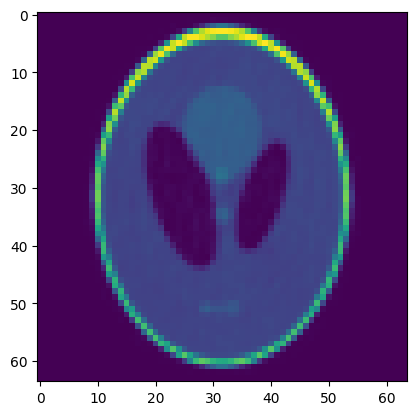

In [81]:
# Init stuff
image_gt = init_phantom().to(device)         # Shape: (1, 1, H, W); Dtype = complex64
csm = torch.tensor(birdcage_maps((4, 64, 64), r=1.1, dtype=np.complex64))  # Shape format (C,H,W)
csm, fg = set_background_sensitivity_to_zero(csm, image_gt)

R = MeasurementRepr().to(device)
A = ForwardOperator(csm)
# G = ReconstructorSimple(device)
G = ReconstructorCGSENSE(device)

kcoords_true = init_kcoords(accel=1.5).to(device)   # Shape: (ksamples, 2)
A.set_coords(kcoords_true)
kdata_true = A(image_gt).clone().detach()  # Shape: (ksamples, 1); Dtype = complex64

# Simulate miscalibration
kcoords_miscalib = kcoords_true + torch.randn_like(kcoords_true) * torch.pi * 0.01
kcoords_miscalib = torch.clip(kcoords_miscalib, -torch.pi, torch.pi)

print(kdata_true.shape)

# Sanity check
recon = G(kdata_true, A)
plt.imshow(recon.abs().squeeze().detach()); plt.show()


### Test framework

In [82]:
def loss_fitting(kdata, kdata_pred_r):             return torch.norm(kdata - kdata_pred_r, p=2)
def loss_consistency(kdata_pred_r, kdata_pred_ag): return torch.norm(kdata_pred_r - kdata_pred_ag, p=2)

100%|██████████| 1000/1000 [02:58<00:00,  5.59it/s]


226.45310974121094


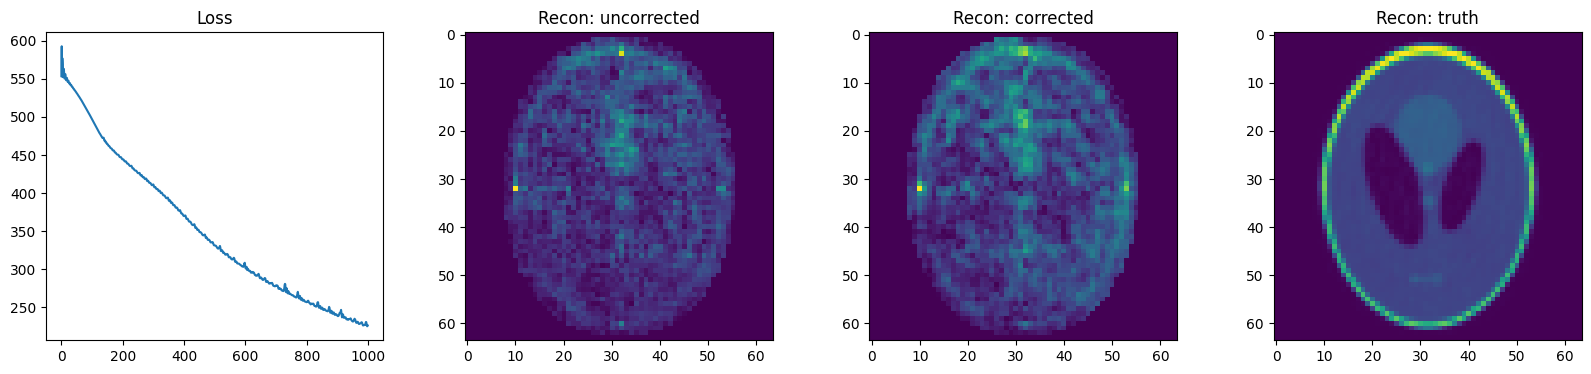

In [87]:
# Optimization prep
kcoords = kcoords_miscalib.clone().detach().to(device)
kcoords.requires_grad = True
params = itertools.chain([kcoords], R.parameters())
optimizer = torch.optim.Adam(params, lr=1e-4)
consistency_weight = 1e-2

# Optimization loop
num_iters = 1000
loss_history = []
for it in tqdm(range(num_iters)):
        
    optimizer.zero_grad()

    A.set_coords(kcoords)
    kdata_pred_r = R(kcoords)  # Shape: {ksamples, 1}
    kdata_pred_ag = A(G(kdata_pred_r, A))  # Shape: {ksamples, 1}
    loss = loss_fitting(kdata_true, kdata_pred_r) + consistency_weight * loss_consistency(kdata_pred_r, kdata_pred_ag)
    
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())


# Results
print(loss_history[-1])

A.set_coords(kcoords_miscalib); recon_uncorrected = G(R(kcoords_miscalib), A)
A.set_coords(kcoords);          recon_corrected = G(R(kcoords), A)
A.set_coords(kcoords_true);     recon_true = G(kdata_true, A)

fig, axs = plt.subplots(1, 4, figsize=(20, 4))
axs[0].plot(loss_history); axs[0].set_title("Loss")
axs[1].imshow(recon_uncorrected.abs().squeeze().detach().cpu()); axs[1].set_title("Recon: uncorrected")
axs[2].imshow(recon_corrected.abs().squeeze().detach().cpu()); axs[2].set_title("Recon: corrected")
axs[3].imshow(recon_true.abs().squeeze().detach().cpu()); axs[3].set_title("Recon: truth")
plt.show()